# EDA: PCB Defect Dataset — Goal and Scope

This notebook performs a focused exploratory data analysis (EDA) for the PCB defect dataset. The goal is to quickly verify the dataset structure, inspect example images (template vs test), produce a difference map that highlights defects, and generate a small set of summary statistics and visual artifacts saved to disk.

Key checks and outputs:

- Confirm dataset path and list available sample groups (train/test splits if present).
- Inspect one example group's files and verify expected inner folder layout (e.g., `group00041/00041`).
- Visualize a Template (defect-free) image next to a Test (defective) image for a quick visual comparison.
- Create a grayscale absolute-difference map (bright regions indicate defect areas) and display it.
- Compute and plot image size statistics (height/width distribution sampled across groups), and save plots and preview images to `EDA_Output/`.


## Setup — Imports & Dataset Path

This cell imports the minimal libraries used in the notebook (OpenCV, matplotlib, NumPy) and sets the dataset path (`DATA_PATH`) and an output folder (`EDA_Output`) for preview images and plots. Run this first to ensure subsequent cells can access the dataset.

In [ ]:
# Imported Libraries
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Minimal plotting style
plt.style.use('seaborn-v0_8')

# Set dataset path (explicit prefer workspace data folder)
DATA_PATH = r"D:\OneDrive\Desktop\PCBDEFECT_DETECTION\data"
if not os.path.isdir(DATA_PATH):
    # fallback to relative 'data' if explicit path not present
    DATA_PATH = os.path.abspath('data')

print(f"Dataset path found: {DATA_PATH}")

# Output folder for quick previews
OUTPUT_DIR = os.path.join(os.getcwd(), 'EDA_Output')
os.makedirs(OUTPUT_DIR, exist_ok=True)


Dataset path found: D:\OneDrive\Desktop\PCBDEFECT_DETECTION\data


## Dataset Overview — List Groups & Split Files

This cell lists the `group*` directories found under `DATA_PATH` and prints whether `trainval.txt` and `test.txt` exist (and their counts). Run this to confirm dataset grouping and available split files.

In [2]:
# List group directories and show sample group names (like image)
group_dirs = [d for d in os.listdir(DATA_PATH) if d.startswith('group')]
print(f"Total number of PCB sample groups: {len(group_dirs)}")
print(group_dirs[:10])

# Show trainval and test lists if available
trainval_path = os.path.join(DATA_PATH, 'trainval.txt')
test_path = os.path.join(DATA_PATH, 'test.txt')
if os.path.exists(trainval_path):
    with open(trainval_path, 'r') as f:
        train_list = [l.strip() for l in f if l.strip()]
    print(f"trainval groups: {len(train_list)}")
else:
    print('trainval.txt not found')

if os.path.exists(test_path):
    with open(test_path, 'r') as f:
        test_list = [l.strip() for l in f if l.strip()]
    print(f"test groups: {len(test_list)}")
else:
    print('test.txt not found')


Total number of PCB sample groups: 11
['group00041', 'group12000', 'group12100', 'group12300', 'group13000', 'group20085', 'group44000', 'group50600', 'group77000', 'group90100']
trainval groups: 1000
test groups: 500


## Structure Check — Inspect One Group's Inner Folder

This cell inspects the inner folder of the first `group*` found (e.g., `group00041/00041`), lists the filenames present, and identifies a template and a test image to use for visualization.

In [4]:
# Check image structure (template vs test) for first sample group
if len(group_dirs) == 0:
    print('No groups available in DATA_PATH')
else:
    sample_group = group_dirs[0]
    sample_path = os.path.join(DATA_PATH, sample_group)
    inner_folder = os.path.basename(sample_group).replace('group', '')
    inner_path = os.path.join(sample_path, inner_folder)
    print('Sample group =', sample_group)
    print('Inner folder expected =', inner_folder)

    if os.path.isdir(inner_path):
        files = os.listdir(inner_path)
        print('Files inside:', files[:50])
        # pick files containing 'temp' for template and 'test' for test image
        template_path = next((os.path.join(inner_path, f) for f in files if 'temp' in f.lower()), None)
        test_path_img = next((os.path.join(inner_path, f) for f in files if 'test' in f.lower()), None)
        print('Template path:', template_path)
        print('Test path:', test_path_img)
    else:
        print('Inner path not found:', inner_path)


Sample group = group00041
Inner folder expected = 00041
Files inside: ['00041000_temp.jpg', '00041000_test.jpg', '00041001_temp.jpg', '00041001_test.jpg', '00041002_temp.jpg', '00041002_test.jpg', '00041003_temp.jpg', '00041003_test.jpg', '00041004_temp.jpg', '00041004_test.jpg', '00041005_temp.jpg', '00041005_test.jpg', '00041006_temp.jpg', '00041006_test.jpg', '00041007_temp.jpg', '00041007_test.jpg', '00041008_temp.jpg', '00041008_test.jpg', '00041009_temp.jpg', '00041009_test.jpg', '00041010_temp.jpg', '00041010_test.jpg', '00041011_temp.jpg', '00041011_test.jpg', '00041012_temp.jpg', '00041012_test.jpg', '00041013_temp.jpg', '00041013_test.jpg', '00041014_temp.jpg', '00041014_test.jpg', '00041015_temp.jpg', '00041015_test.jpg', '00041016_temp.jpg', '00041016_test.jpg', '00041017_temp.jpg', '00041017_test.jpg', '00041018_temp.jpg', '00041018_test.jpg', '00041019_temp.jpg', '00041019_test.jpg', '00041020_temp.jpg', '00041020_test.jpg', '00041021_temp.jpg', '00041021_test.jpg', '0004

## Visual Comparison — Template vs Test and Difference Map

This cell displays the selected Template (defect-free) and Test (defective) image side-by-side and computes a grayscale absolute-difference map where bright regions indicate potential defects. It also saves preview images to `EDA_Output/previews/`.

Checking paths:
 template_path = D:\OneDrive\Desktop\PCBDEFECT_DETECTION\data\group00041\00041\00041000_temp.jpg
 test_path_img = D:\OneDrive\Desktop\PCBDEFECT_DETECTION\data\group00041\00041\00041000_test.jpg


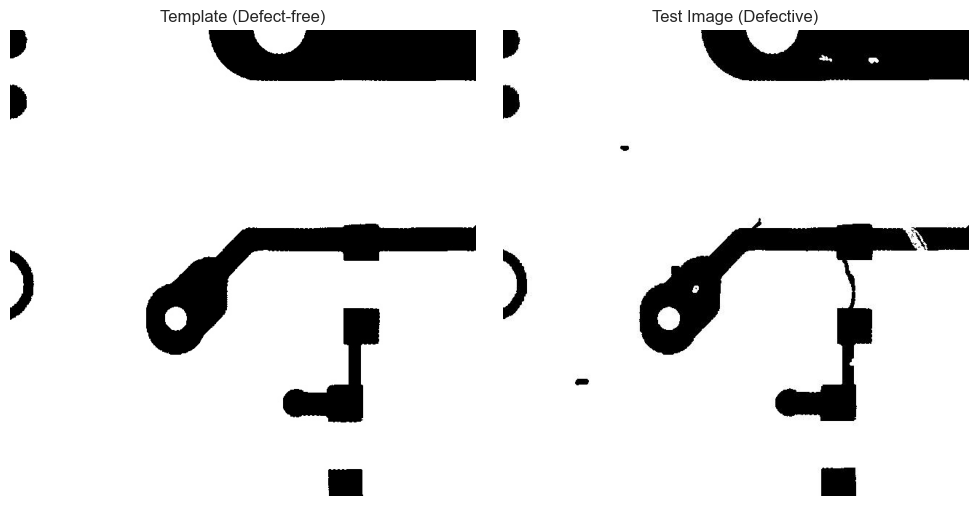

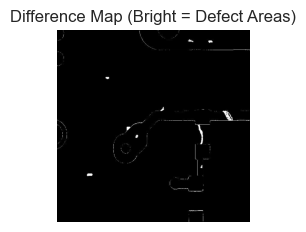

Saved preview images to d:\OneDrive\Desktop\PCBDEFECT_DETECTION\visualize\EDA_Output\previews


In [7]:
# Visualize Template vs Test and show difference map (single example)
if 'template_path' not in globals() or 'test_path_img' not in globals():
    print('Run previous cell to set template_path and test_path_img')
else:
    print('Checking paths:')
    print(' template_path =', template_path)
    print(' test_path_img =', test_path_img)

    # Ensure the path variables exist and are not None before checking filesystem
    if 'template_path' not in globals() or template_path is None:
        print('template_path is not set. Run the Structure Check cell (above) to set it.')
    else:
        if not os.path.exists(template_path):
            print('Template file not found:', template_path)

    if 'test_path_img' not in globals() or test_path_img is None:
        print('test_path_img is not set. Run the Structure Check cell (above) to set it.')
    else:
        if not os.path.exists(test_path_img):
            print('Test file not found:', test_path_img)

    # Only attempt to read images if both path variables exist and point to files
    template = None
    test = None
    if 'template_path' in globals() and template_path is not None and os.path.exists(template_path):
        template = cv2.imread(template_path)
    if 'test_path_img' in globals() and test_path_img is not None and os.path.exists(test_path_img):
        test = cv2.imread(test_path_img)

    # Provide clearer error message if reading failed
    if template is None:
        print('Failed to read template image (cv2.imread returned None):', template_path)
    if test is None:
        print('Failed to read test image (cv2.imread returned None):', test_path_img)

    if template is None or test is None:
        print('Cannot proceed with visualization; check paths and image files')
    else:
        # Convert to RGB for plotting
        def to_rgb(img):
            if img.ndim == 2:
                return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        template_rgb = to_rgb(template)
        test_rgb = to_rgb(test)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(template_rgb)
        ax[0].set_title('Template (Defect-free)')
        ax[0].axis('off')

        ax[1].imshow(test_rgb)
        ax[1].set_title('Test Image (Defective)')
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

        # difference map
        gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        gray_test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(gray_test, gray_template)

        plt.figure(figsize=(8,2.5))
        plt.imshow(diff, cmap='gray')
        plt.title('Difference Map (Bright = Defect Areas)')
        plt.axis('off')
        plt.show()

        # save previews
        preview_dir = os.path.join(OUTPUT_DIR, 'previews')
        os.makedirs(preview_dir, exist_ok=True)
        cv2.imwrite(os.path.join(preview_dir, 'template_preview.jpg'), template)
        cv2.imwrite(os.path.join(preview_dir, 'test_preview.jpg'), test)
        cv2.imwrite(os.path.join(preview_dir, 'diff_preview.jpg'), diff)
        print('Saved preview images to', preview_dir)


## Image Size Stats — Height & Width Distribution

This cell samples a single test image per group (up to 50 groups), computes image heights and widths, prints the averages, plots histograms of both dimensions, and saves the figure to `EDA_Output/image_size_distribution.png`.

Average Height: 640.00, Average Width: 640.00


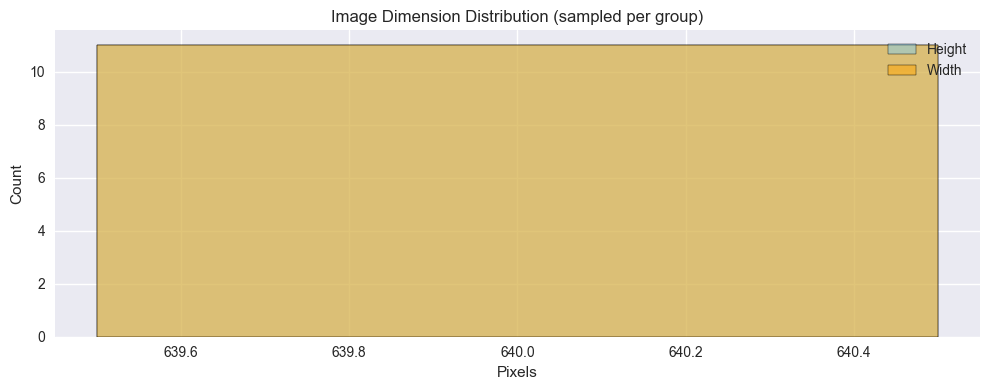

Saved image size distribution to d:\OneDrive\Desktop\PCBDEFECT_DETECTION\visualize\EDA_Output\image_size_distribution.jpg


In [8]:
# Image size statistics across dataset (sample first test image per group)
import numpy as np
import seaborn as sns

heights = []
widths = []

# Ensure we have group_dirs; fall back to listing DATA_PATH
if 'group_dirs' not in globals():
    group_dirs = [d for d in os.listdir(DATA_PATH) if d.startswith('group')]

# Limit to first 50 groups for speed (like the image)
for group in group_dirs[:50]:
    inner_folder = os.path.basename(group).replace('group', '')
    inner_path = os.path.join(DATA_PATH, group, inner_folder)
    if not os.path.isdir(inner_path):
        continue
    # pick a 'test' file if available
    test_files = [f for f in os.listdir(inner_path) if 'test' in f.lower()]
    if not test_files:
        continue
    test_img_path = os.path.join(inner_path, test_files[0])
    img = cv2.imread(test_img_path)
    if img is None:
        continue
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)

if len(heights) == 0:
    print('No readable test images found to compute image size statistics')
else:
    print(f"Average Height: {np.mean(heights):.2f}, Average Width: {np.mean(widths):.2f}")
    plt.figure(figsize=(10,4))
    sns.histplot(heights, color='skyblue', kde=True, label='Height')
    sns.histplot(widths, color='orange', kde=True, label='Width')
    plt.legend()
    plt.title('Image Dimension Distribution (sampled per group)')
    plt.xlabel('Pixels')
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, 'image_size_distribution.jpg')
    plt.savefig(out_path, dpi=200)
    plt.show()
    print('Saved image size distribution to', out_path)
